In [ ]:
import random, shutil
from pathlib import Path

In [ ]:
root = Path('./road_sign_datasets')
Path('./road_sign_datasets/data').mkdir(parents=True, exist_ok=True)

In [ ]:
for path1 in ('images', 'labels'):
    for path2 in ('train2007', 'val2007', 'test2007'):
        new_path = root / 'SIGN' / path1 / path2
        new_path.mkdir(parents=True, exist_ok=True)

In [ ]:
%cd /content/road_sign_datasets/data

/content/road_sign_datasets/data


In [ ]:
!unzip -q roadSign.zip

In [ ]:
%cd /content/road_sign_datasets

/content/road_sign_datasets


In [ ]:
!git clone https://github.com/ssaru/convert2Yolo.git

Cloning into 'convert2Yolo'...
remote: Enumerating objects: 215, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 215 (delta 38), reused 35 (delta 35), pack-reused 172 (from 1)
Receiving objects: 100% (215/215), 994.67 KiB | 21.16 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [ ]:
%cd convert2Yolo/

/content/road_sign_datasets/convert2Yolo


In [ ]:
%pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.1/39.1 MB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 14.9 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
!python example.py \
    --datasets VOC \
    --img_path /content/road_sign_datasets/data/images \
    --label /content/road_sign_datasets/data/annotations \
    --convert_output_path /content/road_sign_datasets/SIGN/labels/train2007 \
    --img_type '.png' \
    --manifest_path /content/road_sign_datasets \
    --cls_list_file ./voc.names


VOC Parsing:   |████████████████████████████████████████| 100.0% (877/877)  Complete


YOLO Generating:|████████████████████████████████████████| 100.0% (877/877)  Complete


YOLO Saving:   |████████████████████████████████████████| 100.0% (877/877)  Complete



In [ ]:
import random, shutil

In [ ]:
label_train = Path("/content/road_sign_datasets/SIGN/labels/train2007")
label_val   = Path("/content/road_sign_datasets/SIGN/labels/val2007")
label_test  = Path("/content/road_sign_datasets/SIGN/labels/test2007")
label_val.mkdir(parents=True, exist_ok=True)
label_test.mkdir(parents=True, exist_ok=True)


ids = sorted([p.stem for p in label_train.glob("*.txt")])
print("total label ids:", len(ids))

random.seed(42)
random.shuffle(ids)

test_ratio = 0.1
val_ratio  = 0.2

n = len(ids)
n_test = int(n * test_ratio)
n_val  = int(n * val_ratio)

test_ids = set(ids[:n_test])
val_ids  = set(ids[n_test:n_test+n_val])
train_ids= set(ids[n_test+n_val:])

print("train/val/test:", len(train_ids), len(val_ids), len(test_ids))

split_dir = Path("/content/road_sign_datasets/splits")
split_dir.mkdir(parents=True, exist_ok=True)
(split_dir/"train.txt").write_text("\n".join(sorted(train_ids))+"\n")
(split_dir/"val.txt").write_text("\n".join(sorted(val_ids))+"\n")
(split_dir/"test.txt").write_text("\n".join(sorted(test_ids))+"\n")

moved_v, moved_t = 0, 0
for id_ in val_ids:
    src = label_train / f"{id_}.txt"
    dst = label_val / f"{id_}.txt"
    if src.exists() and not dst.exists():
        shutil.move(str(src), str(dst))
        moved_v += 1

for id_ in test_ids:
    src = label_train / f"{id_}.txt"
    dst = label_test / f"{id_}.txt"
    if src.exists() and not dst.exists():
        shutil.move(str(src), str(dst))
        moved_t += 1

print("moved val:", moved_v, "moved test:", moved_t)
print("labels train/val/test:",
      len(list(label_train.glob("*.txt"))),
      len(list(label_val.glob("*.txt"))),
      len(list(label_test.glob("*.txt"))))

total label ids: 877
train/val/test: 615 175 87
moved val: 175 moved test: 87
labels train/val/test: 615 175 87


In [ ]:
img_src = Path("/content/road_sign_datasets/data/images")

img_train = Path("/content/road_sign_datasets/SIGN/images/train2007")
img_val   = Path("/content/road_sign_datasets/SIGN/images/val2007")
img_test  = Path("/content/road_sign_datasets/SIGN/images/test2007")

img_train.mkdir(parents=True, exist_ok=True)
img_val.mkdir(parents=True, exist_ok=True)
img_test.mkdir(parents=True, exist_ok=True)

def copy_imgs_from_labels(label_dir: Path, out_dir: Path, ext=".png"):
    copied, missing = 0, 0
    for lb in label_dir.glob("*.txt"):
        stem = lb.stem
        src = img_src / f"{stem}{ext}"
        if not src.exists():
            alt = list(img_src.glob(stem + ".*"))
            if alt:
                src = alt[0]
            else:
                missing += 1
                continue
        dst = out_dir / src.name
        if dst.exists():
            continue
        shutil.copy2(src, dst)
        copied += 1
    return copied, missing

c1, m1 = copy_imgs_from_labels(Path("/content/road_sign_datasets/SIGN/labels/train2007"), img_train)
c2, m2 = copy_imgs_from_labels(Path("/content/road_sign_datasets/SIGN/labels/val2007"), img_val)
c3, m3 = copy_imgs_from_labels(Path("/content/road_sign_datasets/SIGN/labels/test2007"), img_test)

print("copied train/val/test:", c1, c2, c3)
print("missing train/val/test:", m1, m2, m3)
print("images train/val/test:",
      len(list(img_train.glob("*.*"))),
      len(list(img_val.glob("*.*"))),
      len(list(img_test.glob("*.*"))))

copied train/val/test: 615 175 87
missing train/val/test: 0 0 0
images train/val/test: 615 175 87


In [ ]:
from pathlib import Path

img_src = Path("/content/road_sign_datasets/data/images")
label_dir = Path("/content/road_sign_datasets/SIGN/labels/train2007")

samples = sorted(label_dir.glob("*.txt"))[:10]
print("label sample count:", len(samples))

for lb in samples:
    stem = lb.stem
    img = img_src / f"{stem}.png"
    print(lb.name, "->", img.name, "exists:", img.exists())

label sample count: 10
road0.txt -> road0.png exists: True
road1.txt -> road1.png exists: True
road10.txt -> road10.png exists: True
road100.txt -> road100.png exists: True
road101.txt -> road101.png exists: True
road103.txt -> road103.png exists: True
road104.txt -> road104.png exists: True
road105.txt -> road105.png exists: True
road106.txt -> road106.png exists: True
road108.txt -> road108.png exists: True


In [ ]:
from pathlib import Path

names = ["trafficlight", "stop", "speedlimit", "crosswalk"]

yaml_path = Path("/content/road_sign_data.yaml")
yaml_text = f"""path: /content/road_sign_datasets/SIGN
train: images/train2007
val: images/val2007
test: images/test2007

nc: {len(names)}
names: {names}
"""
yaml_path.write_text(yaml_text)
print(yaml_path.read_text())

path: /content/road_sign_datasets/SIGN
train: images/train2007
val: images/val2007
test: images/test2007

nc: 4
names: ['trafficlight', 'stop', 'speedlimit', 'crosswalk']



In [ ]:
!pip -q install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.8 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
model = YOLO("yolov8s.pt")
results = model.train(
    data="/content/road_sign_data.yaml",
    epochs=30,
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    name="road_sign_yolov8s"
)

Ultralytics 8.3.249 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/road_sign_data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=road_sign_yolov8s, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tru

save_dir: /content/road_sign_datasets/convert2Yolo/runs/detect/road_sign_yolov8s
results.csv exists: True /content/road_sign_datasets/convert2Yolo/runs/detect/road_sign_yolov8s/results.csv


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
25,26,452.887,0.51185,0.31346,0.85221,0.98252,0.92525,0.95646,0.81069,0.62134,0.37549,0.92612,0.000219,0.000219,0.000219
26,27,470.418,0.50014,0.30041,0.84241,0.96902,0.93750,0.95343,0.81420,0.60227,0.37701,0.91043,0.000178,0.000178,0.000178
27,28,487.092,0.48913,0.30060,0.85291,0.97643,0.93559,0.96684,0.81359,0.60169,0.34992,0.92508,0.000136,0.000136,0.000136
28,29,503.546,0.49348,0.29001,0.83748,0.94662,0.95312,0.97061,0.82051,0.59414,0.32787,0.91876,0.000095,0.000095,0.000095
29,30,520.432,0.47641,0.28859,0.83873,0.94694,0.95773,0.97356,0.82100,0.58555,0.32087,0.91106,0.000054,0.000054,0.000054


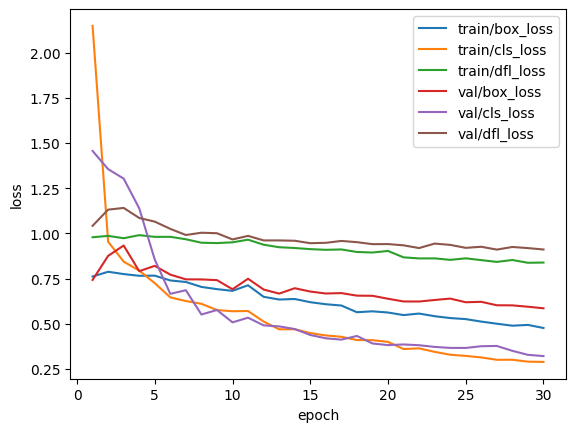

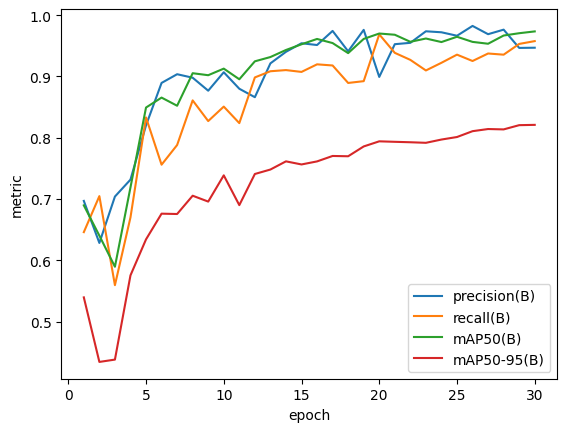

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 이번 train 결과 저장 폴더를 results에서 가져오기 (가장 정확)
save_dir = Path(str(results.save_dir))
print("save_dir:", save_dir)

csv_path = save_dir / "results.csv"
print("results.csv exists:", csv_path.exists(), csv_path)

df = pd.read_csv(csv_path)

# 2) 표로 확인 (마지막 5 epoch)
display(df.tail(5))

# 3) loss 그래프
plt.figure()
plt.plot(df["epoch"], df["train/box_loss"], label="train/box_loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="train/cls_loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="train/dfl_loss")
plt.plot(df["epoch"], df["val/box_loss"], label="val/box_loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="val/cls_loss")
plt.plot(df["epoch"], df["val/dfl_loss"], label="val/dfl_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.show()

# 4) metrics 그래프
plt.figure()
plt.plot(df["epoch"], df["metrics/precision(B)"], label="precision(B)")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="recall(B)")
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP50(B)")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP50-95(B)")
plt.xlabel("epoch"); plt.ylabel("metric"); plt.legend(); plt.show()